# Generalización para codigos de Superficie con distancia arbitraria

Se comienza con una generalización para un codigo de superficie. Se puede apreciar para codigos de corta distancia como $d=3$ o $d=5$ en los cuales es sencilla la visualización. Se comienza definiendo que para cualquier codigo de superficie de distacia $d$ se va a tener $d^2$ qubits de datos y $d^2 -1$ qubits ancilares. Con esto se presenta una ditribución para $d=5$ de manera clasica y una propuesta geometrica similar que permite mapear los qubits de manera arbitraria para cualquier $d$.

<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center;">
    <img src="Distance5Code.jpeg" width="400"/>
    <p style="font-size: 14px;">Figura 1: Representación Clasica</p>
  </div>
  <div style="text-align: center;">
    <img src="DistribuciónD5Kayro.jpeg" width="400"/>
    <p style="font-size: 14px;">Figura 2: Representación Propuesta</p>
  </div>
</div>
<p>
La imagen anterior da una representación clásica donde se logra mapear cada qubit a una coordenada, sin embargo, esto puede aumentar el tamaño de la grilla innecesariamente, en especial en las aristas. Es por ello que se propone una geometría similar en la cual todos los qubits se ven contenidos en una grilla de tamaño \(2d^2 - 1\). Asimismo, es valioso denotar que los qubits de datos se representan como puntos rojos mientras que los ancilares se representan con puntos turquesa. Las mediciones \(X\) se representan con líneas azules y las \(Z\) con líneas rosas.
</p>

Con esta nueva geometría propuesta se puede desarrolla un mapeo arbitrario para cualquier codigo de longitud $d$ que se presenta a continuacion:

In [67]:
import stim
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns

In [68]:
# Se define la distancia del código
d = 5

# Se define cuántos qubits de datos se van a tener
data_qubits = d*d
# Cantidad de qubits ancillares
ancilla_qubits = (d*d) - 1

total_qubits = data_qubits + ancilla_qubits

In [69]:
def Qubits_coordinates(total_qubits):
    # Para este apartado se propone una distribución como se ve en la Figura 2
    # Se comienzan dos listas las cuales guardarán las ubicaciones en una grilla como la de la figura
    data_coords = []
    ancilla_coords = []
    # Se hace un ciclo que va a recorrer toda la grilla que contiene coordenadas y se define cada punto como data o ancilla
    for i in range (total_qubits):
        for j in range (total_qubits):
            # Se puede definir el índice para recorrer la matriz de manera continua
            # Se determinan primero las posiciones de los data qubits
            if i%2 == 0 and j%2 == 0:
                data_coords.append((i,j))
            # Se determinan las posiciones de los ancilla qubits sin tomar en cuenta los bordes
            if i%2 != 0 and j%2 != 0:
                ancilla_coords.append((i,j))
            # Se definen los ancilla en los bordes según la geometría propuesta en la Figura 2
            # Bordes horizontales
            if i == 0 and 4*j + 3 < total_qubits:
                ancilla_coords.append((i, 4*j + 3)) # Esta ecuación 4j+3 separa los impares 1,5,9... de los otros 3,7,11...
            if i == total_qubits - 1 and 4*j + 1 < total_qubits:
                ancilla_coords.append((i, 4*j + 1))
            # Bordes verticales
            if j == 0 and 4*i + 1 < total_qubits:
                ancilla_coords.append((4*i + 1, j))
            if j == total_qubits - 1 and 4*i + 3 < total_qubits:
                ancilla_coords.append((4*i + 3, j))

    return data_coords, ancilla_coords

# Al llamar esta función, cada qubit según la distribución en la Figura 2 se encuentra asociado a un par ordenado
# Con esto se busca obtener una biyección que relacione los números naturales con cada par ordenado, siguiendo la numeración clásica del código
# Se comienza numerando los qubits de data de 1 a d^2 y los ancillares con números de d^2 a total_qubits

In [70]:
# Se propone una función que realice un diccionario que genere una biyección par ordenado <-> número de qubit
def Qubits_pair_num(data_coords # Lista de pares ordenados referentes a los qubits de datos,
                    ,ancilla_coords # Lista de pares ordenados referentes a los qubits ancilla,
                    ,d # Distancia del código
):
    # Diccionario que guarda par ordenado: número
    qubits_coords_num = {}
    # Se propone un ordenamiento para los data como suele ser en un surface code
    data_order = sorted(data_coords, key=lambda coord: (coord[0], coord[1]))
    # Se asignan los números a los datos ordenados como se quiere
    for idx, coord in enumerate(data_order, start=1):
        qubits_coords_num[coord] = idx

    # Se ordenan las ancillas por pares ordenados
    ancilla_order = sorted(ancilla_coords, key=lambda coord: (coord[0], coord[1]))
    # Se define el número donde comienzan los números de los ancilla
    start_ancilla = d*d+1
    # Se asignan los números de qubits_ancilla a los restantes
    for idx, coord in enumerate(ancilla_order, start=start_ancilla):
        qubits_coords_num[coord] = idx

    # Se invierte el diccionario para obtener una función que relacione los números de qubit a sus coordenadas y, posterior a eso, poder 
    # relacionar los números de qubit con sus adyacentes
    qubits_num_coords = {num: coord for coord, num in qubits_coords_num.items()}
    
    return qubits_num_coords

In [71]:
# Se define una función que va a clasificar las ancillas según la geometría de la Figura 2, en donde determina si una ancilla es X o Z
def Class_ancilla(qubits_num_coords # Diccionario que relaciona el número del qubit a su par ordenado
                        , d # Distancia del código
                       ):
    # Se define el inicio del número de qubits ancillares y el final
    start = d*d + 1
    end = 2*d*d - 1
    total_qubits = 2*d - 1

    # Se define un diccionario vacío que va a relacionar el número de qubit con si es un estabilizador X o Z
    tipos_num = {}

    # Se define una función auxiliar que va a clasificar a cada qubit individualmente por su posición
    def Stabil_coords(i, j):
        # Se analizan los puntos internos a los bordes del código
        if i % 2 == 1 and j % 2 == 1:
            if i % 4 == 1:
                return 'X' if (j % 4 == 1) else 'Z'
            else:
                return 'X' if (j % 4 == 3) else 'Z'
        # Se analizan los puntos en los bordes de la grilla
        if i == 0:
            return 'X' if (j % 4 == 3) else 'Z'
        if i == total_qubits - 1:
            return 'X' if (j % 4 == 1) else 'Z'
        if j == 0:
            return 'X' if (i % 4 == 1) else 'Z'
        if j == total_qubits - 1:
            return 'X' if (i % 4 == 3) else 'Z'
        return 'Z'

    # Se extraen y se clasifica cada ancilla
    for num, (i, j) in qubits_num_coords.items():
        if start <= num <= end:
            tipos_num[num] = Stabil_coords(i, j)

    return tipos_num

In [72]:
# Se define una función de distancia
def Dist(data_q, ancilla_q):
    return math.hypot(data_q[0] - ancilla_q[0], data_q[1] - ancilla_q[1])

In [73]:
def Ancil_per_data(qubits_num_coords # Diccionario que asocia el número de qubit a par ordenado
                   , d):
    # Se comienza definiendo el radio donde pueden existir los ancillares para el data
    radio = 2**(0.5)

    # Se definen los qubits de datos y dónde comienza y termina la numeración de los ancillares
    data_qubits = d*d
    start  = data_qubits + 1
    end = 2*data_qubits - 1

    # Se define un diccionario que va a relacionar el número de qubit de data con una lista que representa cada ancillar que le corresponde al data
    ancilla_per_data = {}
    
    # Para cada data qubit
    for data_q in range(1, data_qubits + 1):
        data_posit = qubits_num_coords[data_q]
        vecinos = []

        # Se itera sobre los ancillas
        for ancilla_q in range(start, end + 1):
            ancilla_posit = qubits_num_coords[ancilla_q]
            if Dist(data_posit, ancilla_posit) <= radio:
                vecinos.append(ancilla_q)

        ancilla_per_data[data_q] = vecinos

    # Con el diccionario definido de data a ancilla, es más conveniente tener algo que relacione ancilla a data
    data_per_ancilla = {ancilla_q: [] for ancilla_q in range(start, end + 1)}
    for data_q, ancillas in ancilla_per_data.items():
        for ancilla_q in ancillas:
            data_per_ancilla[ancilla_q].append(data_q)
    
    return data_per_ancilla

Con el codigo anterior se logra una generalización para cualquier codigo de distancia $d$; una vez construida la grilla como en la Figura 2 y conociendo los ancilla relacionados a cada data se proponen las gates necesarias para relacionar cada qubit. Es importante saber que al aplicar todas las funciones anteriores tenemos 3 diccionarios los cuales son: 
- qubits_num_coords: Relaciona un número de qubit a un par ordenado, contiene todos lo qubits data y ancilla
- tipos_num: Relaciona el número relacionado a cada qubit ancilla con su respectivo estabilizador X o Z
- data_per_ancilla: Relaciona cada uno de los qubits ancilla con una lista de qubits data que son los que medirían el qubit de data


Con esto se propone una función que realice el circuito cuántico, donde se reinician todos los qubits, luego se realizan las relaciones ancila-data

In [74]:
def Quantum_circuit(tipos_num # Diccionario que relaciona el número ancilla con X o Z
                   , data_per_ancilla # Diccionario que relaciona cada número de qubit ancilla con una lista de qubits data
                    , d # Distancia del código
                    , shots # Cantidad de repeticiones del código completo, sirve para hacer estadísticas
                   , rounds # Ciclo completo de medición de estabilizadores. Cada ronda genera síndromes diferentes
                   ):
    # Se definen la cantidad de data y ancilla
    data_qubits = d*d
    ancilla_qubits = (d*d) - 1
    total_qubits = data_qubits + ancilla_qubits
    
    # Se parte generando un circuito vacío
    circuit = stim.Circuit()

    # Se propone un reset masivo para todos los qubits
    circuit.append("R", range(1, total_qubits + 1))
    
    # Se acomodan una vez más las ancillas
    ancillas = sorted(tipos_num.keys())
    # Acá se comienza a definir cada circuito y se empieza un ciclo para las rondas
    for rounds_i in range(rounds):
        for i in tipos_num.keys():
            # Se tratan primero los operadores X
            if tipos_num[i] == "X":
                # Se obtiene la lista de qubits datos asociados
                data_asoc = data_per_ancilla.get(i)
                circuit.append("H", [i])
                # Se aplica a cada qubit la relación
                for k in data_asoc:
                    circuit.append("CNOT", [i,k])
                circuit.append("H", [i])
            # Se tratan los operadores Z
            if tipos_num[i] == "Z":
                # Se obtiene la lista de qubits datos asociados
                data_asoc = data_per_ancilla.get(i)
                # Se aplica a cada qubit la relación
                for k in data_asoc:
                    circuit.append("CNOT", [k,i])

            # Se miden los estabilizadores en este momento y por cada elemento, debido a que al separar los ciclos como en la versión
            # Stim los busca optimizar y esto implica que los relaciona, dando más paso a errores de entrelazamiento
            circuit.append("M", [i])
            circuit.append("DETECTOR", [stim.target_rec(-1)], tag=f"R{rounds_i}_A{i}")

        # Se propone un if que se encarga de reiniciar las ancillas sin ser la última ronda
        if rounds_i < rounds - 1:
            circuit.append("R", list(tipos_num.keys())) 

    # Ponen 2 líneas sugeridas por DS para detección de errores especializados
    sampler = circuit.compile_detector_sampler()
    syndroms = sampler.sample(shots=shots)

    return circuit, syndroms

In [75]:
#Prueba de medida del sistema
measurements = 10
data_ancilla_qubits = Qubits_coordinates(total_qubits)
qubits_pair_num = Qubits_pair_num(data_ancilla_qubits[0],data_ancilla_qubits[1],d)
clasificacion_ancilla = Class_ancilla(qubits_pair_num,d)
ancil_per_data = Ancil_per_data(qubits_pair_num,d)
circuito = Quantum_circuit(clasificacion_ancilla,ancil_per_data,d,1,measurements)

print (circuito)

(stim.Circuit('''
    R 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
    H 26
    CX 26 2 26 3
    H 26
    M 26
    DETECTOR[R0_A26] rec[-1]
    H 27
    CX 27 4 27 5
    H 27
    M 27
    DETECTOR[R0_A27] rec[-1]
    H 28
    CX 28 6 28 7
    H 28
    M 28
    DETECTOR[R0_A28] rec[-1]
    H 29
    CX 29 8 29 9
    H 29
    M 29
    DETECTOR[R0_A29] rec[-1]
    H 30
    CX 30 10 30 11
    H 30
    M 30
    DETECTOR[R0_A30] rec[-1]
    H 31
    CX 31 12 31 13
    H 31
    M 31
    DETECTOR[R0_A31] rec[-1]
    H 32
    CX 32 14 32 15
    H 32
    M 32
    DETECTOR[R0_A32] rec[-1]
    H 33
    CX 33 16 33 17
    H 33
    M 33
    DETECTOR[R0_A33] rec[-1]
    H 34
    CX 34 18 34 19
    H 34
    M 34
    DETECTOR[R0_A34] rec[-1]
    H 35
    CX 35 20 35 21
    H 35
    M 35
    DETECTOR[R0_A35] rec[-1]
    H 36
    CX 36 22 36 23
    H 36
    M 36
    DETECTOR[R0_A36] rec[-1]
    H 37
    CX 37 24

In [76]:
def Sindrome_visual(syndroms # Lista resultante del circuito
                    , d
                    , measurements):
    # Se comienza obteniendo una lista de listas de booleanos y se separa en varias listas que serán los errores por medición
    detectors = np.array_split(circuito[1].flatten(), measurements)

    # Se definen los rangos de los ancilla y sus números como ya se ha hecho
    data_qubits = d*d
    ancilla_qubits = (d*d) - 1
    total_qubits = data_qubits + ancilla_qubits
    
    # Se define el largo del código y valores similares, para hacer un diccionario que relacione los ancilla con sus valores de fallo
    ancilla_fails = {}
    for i in range(data_qubits + 1, total_qubits + 1):
        ancilla_fails[i] = 0

    # Con esto se define un ciclo que va por cada ancilla y por cada lista
    for measurement in range(len(detectors)):
        for j in range(ancilla_qubits):
            if detectors[measurement][j] == True:
                ancilla_fails[data_qubits + j + 1] += 1

    # A este momento se tiene un diccionario que relaciona el número de qubit ancilla con los errores que ha tenido por medición
    # Se propone un gráfico de barras
    plt.figure(figsize=(ancilla_qubits, measurements))  # Tamaño del gráfico
    plt.bar(ancilla_fails.keys(), ancilla_fails.values(), color='teal', edgecolor='black')
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.title("Detection of change in the ancilla qubits", fontsize=20)
    plt.xlabel("Number of qubit", fontsize=20)
    plt.ylabel("Errors occurred in total measurements", fontsize=20)
    plt.tight_layout()
    plt.savefig("Detection of change in the ancilla qubits.png", dpi=300, bbox_inches='tight')
    plt.show()


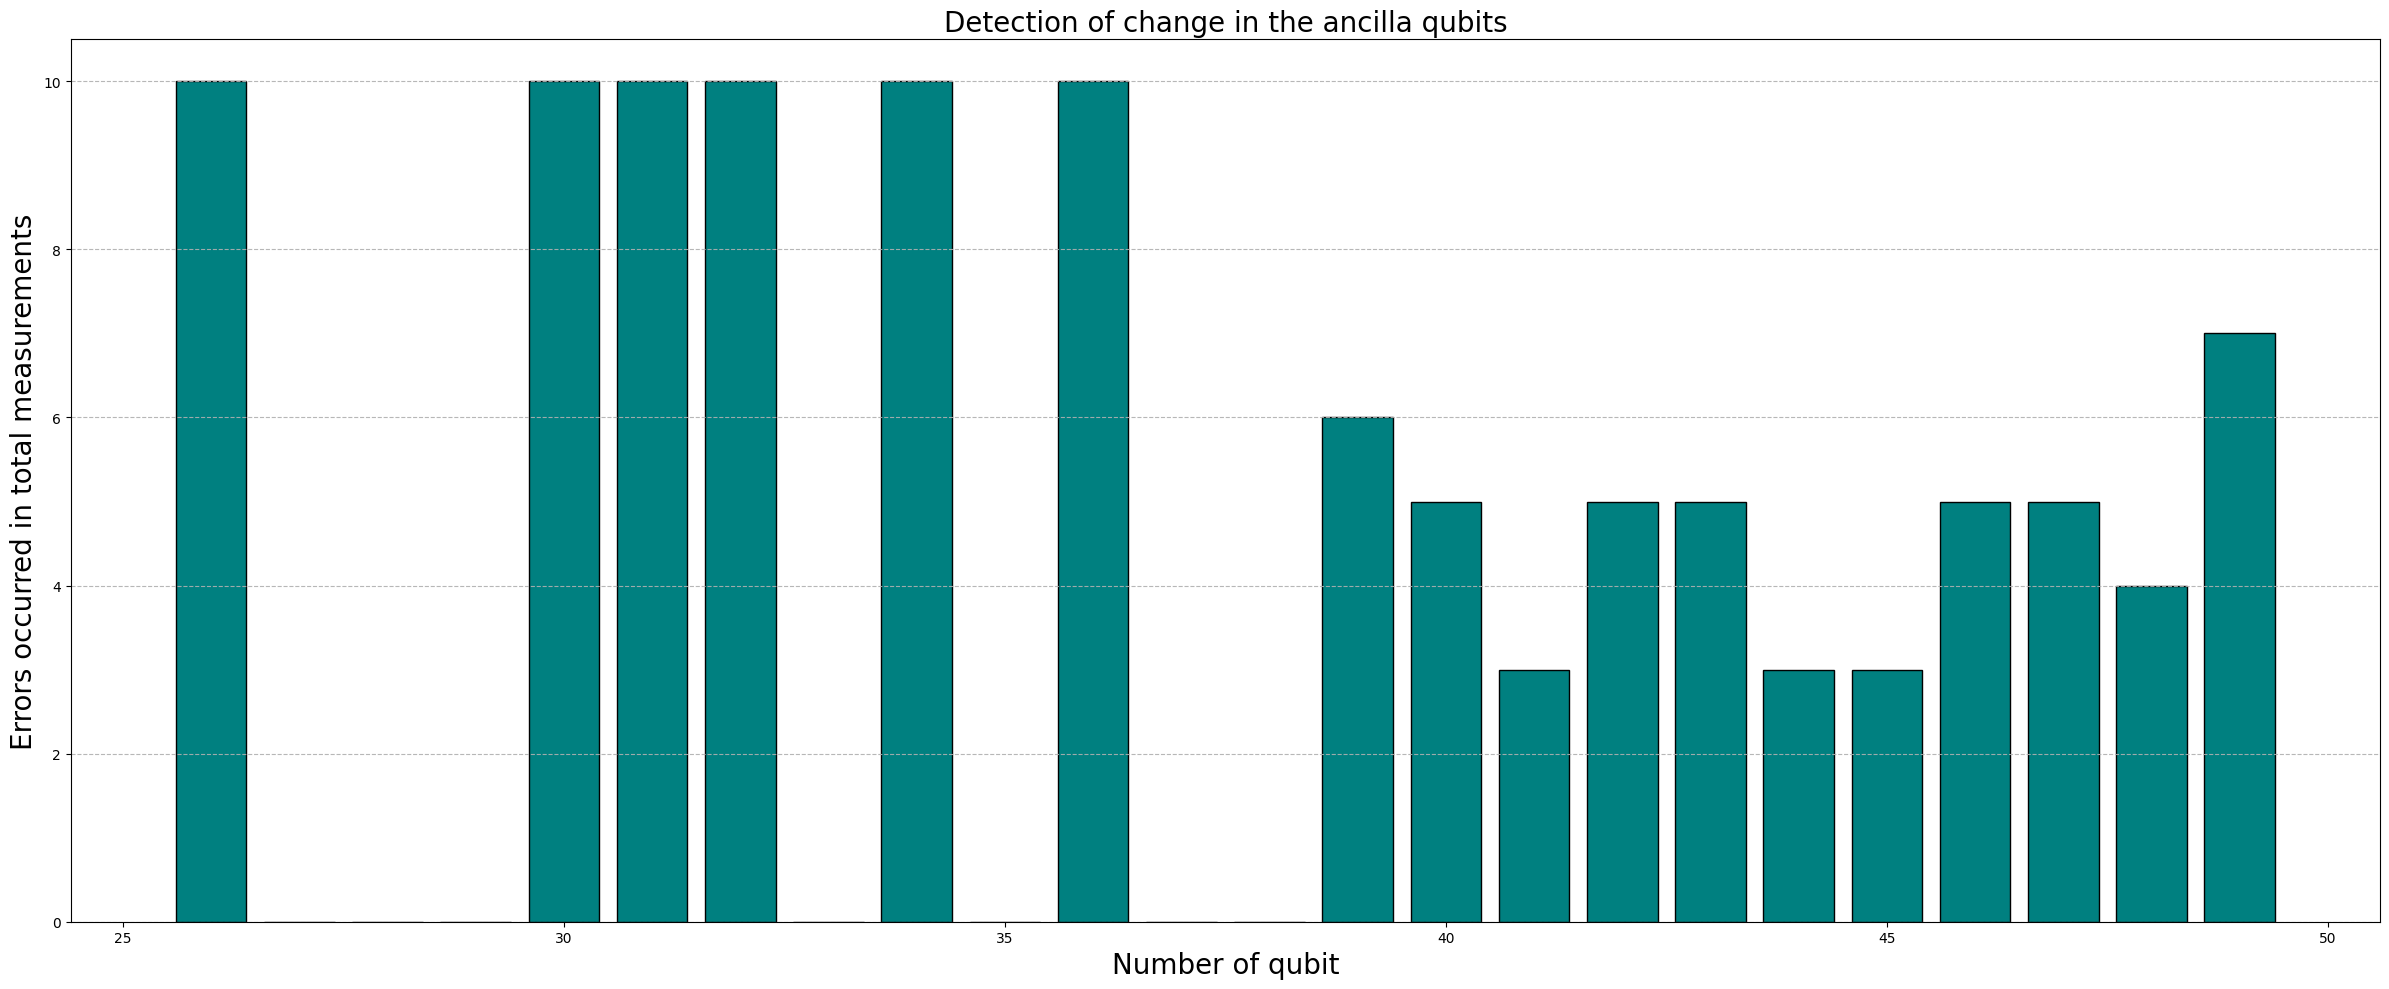

In [77]:
#Se prueba la función de visualización
#print (circuito[1])
Sindrome_visual(circuito[1],d,measurements)
